In [1]:
from pytorch_lightning.utilities import grad_norm
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from copy import deepcopy
from sklearn.metrics import silhouette_score
import pandas as pd 
import torch.optim as optim
from braingeneers.analysis import SpikeData
import os
import json
import pytorch_lightning as pl
from backbones import ResNet18Enc, ResNet18Dec
import wandb
import pickle
from tqdm import tqdm
import scanpy as sc 
import matplotlib.pyplot as plt 
from torch.optim.lr_scheduler import ReduceLROnPlateau
import anndata as an 
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping
import umap
from collections import Counter
import pandas as pd

/Users/jesusgf/opt/miniconda3/envs/electro_phys/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
isi = pd.read_csv('./lookuptable_csv/isitransposed.csv',index_col=0)
print(isi.head())
waveform = pd.read_csv('./lookuptable_csv/Waveforms.csv',index_col=0)
print(waveform.head())
labels = pd.read_csv('./lookuptable_csv/CellType.csv',index_col=0)
print(labels.head())
print(isi.shape, waveform.shape, labels.shape)

          1         2         3         4         5         6          7  \
1  0.656683  0.898352  0.546205  0.653815  2.299961  4.091594   6.022484   
2  1.627675  2.226686  0.193406  1.763883  2.976058  3.961261   7.292329   
3  0.267144  0.348055  0.444401  1.042197  3.405941  7.777678  15.745868   
4  2.602021  3.817549  2.258365  2.445838  2.935041  3.461981   2.929513   
5  1.226348  1.799233  1.596571  1.658325  2.028843  1.783042   1.932975   

           8          9         10  ...        91        92        93  \
1   5.600268  10.765050  25.834541  ...  0.000113  0.000047  0.000120   
2   4.820220   6.955843   9.439580  ...  0.000409  0.000213  0.000170   
3  14.660829  21.462748  30.102711  ...  0.000019  0.000009  0.000000   
4   2.434259   3.952808   8.518674  ...  0.000014  0.000013  0.000024   
5   1.371140   1.276015   1.908533  ...  0.000188  0.000134  0.000100   

         94        95        96        97        98        99       100  
1  0.000055  0.000036  0.00001

In [3]:
#convert to numpy
isi_dist = isi.to_numpy()
waveform = waveform.to_numpy()
labels = labels.to_numpy()
print(isi.shape, waveform.shape, labels.shape)

(430, 100) (430, 46) (430, 1)


In [4]:
min_val = np.min(waveform)
max_val = np.max(waveform)
waveforms = (waveform - min_val) / (max_val - min_val)
# Scale to range [-1, 1]
waveforms = waveforms * 2 - 1
#waveforms = (waveforms - waveforms.mean()) / waveforms.std()
#0 1 normalization
#waveforms = (waveforms - waveforms.min()) / (waveforms.max() - waveforms.min())

isi_dists = isi_dist / isi_dist.sum(axis=1, keepdims=True)

In [5]:
type(isi_dists[0])
type(waveforms[0])
#Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(labels)
print(Counter(labels))


Counter({2: 186, 4: 115, 3: 44, 0: 35, 1: 23, 6: 14, 5: 13})


/Users/jesusgf/opt/miniconda3/envs/electro_phys/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


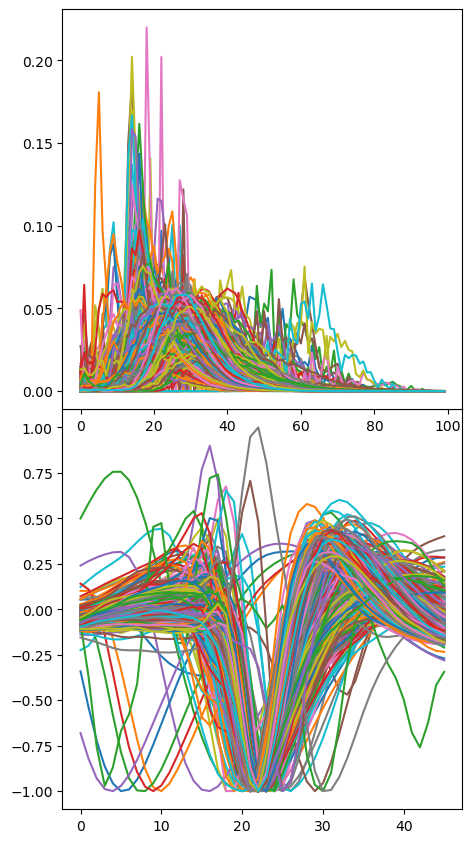

In [6]:
indices_wf = [i for i in range(0, waveforms.shape[1])]
indices_isi = [i for i in range(0, isi_dists.shape[1])]
plt.figure(figsize=(10, 10))
panel1 = plt.axes([0.1, 0.1, 0.4, 0.4])
panel2 = plt.axes([0.1, 0.5, 0.4, 0.4])

for i in range(0, waveforms.shape[0]):
    panel1.plot(indices_wf, waveforms[i])

#panel1.scatter(indices_wf, waveform[0], c='r', s=1)
for i in range(0, isi_dists.shape[0]):
    #print(isi_dist[i])
    panel2.plot(indices_isi, isi_dists[i])

In [7]:
class EphysDatasetLabeled(Dataset):
    def __init__(self, waveforms, isi_dists,labels, normalize=True):
        self.waveforms = np.array(waveforms)
        self.isi_dists = np.array(isi_dists)
        self.labels = np.array(labels)
        #print(len(self.waveforms) , len(self.isi_dists), len(self.labels))
        assert len(self.waveforms) == len(self.isi_dists)
        assert len(self.waveforms) == len(self.labels)
        self.normalize = normalize
        
    def __getitem__(self, idx):
        waveform = torch.as_tensor(self.waveforms[idx, ...]).float()
        
        isi_dist = torch.as_tensor(self.isi_dists[idx, ...]).float()
        isi_dist = torch.log(isi_dist + 1)

        label = torch.as_tensor(self.labels[idx]).long()
        if self.normalize:
            #waveform = (waveform - waveform.mean()) / waveform.std()
            #0 1 normalization
            waveform = (waveform - waveform.min()) / (waveform.max() - waveform.min())
            isi_dist = (isi_dist - isi_dist.mean()) / isi_dist.std()

        waveform = waveform.view(1, 1, -1)
        waveform = F.interpolate(waveform, size=(50,), mode='linear').view(1, -1)
        
        isi_dist = isi_dist.view(1, 1, -1)
        isi_dist = F.interpolate(isi_dist, size=(100,), mode='linear').view(1, -1)

        return waveform, isi_dist, label
    
    def __len__(self):
        return len(self.waveforms)

In [8]:
import torch
is_torchvision_installed = True
try:
    import torchvision
except:
    is_torchvision_installed = False
import torch.utils.data
import random

class BalancedBatchSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, dataset, labels=None):
        self.labels = labels
        self.dataset = dict()
        self.balanced_max = 0
        # Save all the indices for all the classes
        for idx in range(0, len(dataset)):
            label = self._get_label(dataset, idx)
            if label not in self.dataset:
                self.dataset[label] = list()
            self.dataset[label].append(idx)
            self.balanced_max = len(self.dataset[label]) \
                if len(self.dataset[label]) > self.balanced_max else self.balanced_max
        
        # Oversample the classes with fewer elements than the max
        for label in self.dataset:
            while len(self.dataset[label]) < self.balanced_max:
                self.dataset[label].append(random.choice(self.dataset[label]))
        self.keys = list(self.dataset.keys())
        self.currentkey = 0
        self.indices = [-1]*len(self.keys)

    def __iter__(self):
        while self.indices[self.currentkey] < self.balanced_max - 1:
            self.indices[self.currentkey] += 1
            yield self.dataset[self.keys[self.currentkey]][self.indices[self.currentkey]]
            self.currentkey = (self.currentkey + 1) % len(self.keys)
        self.indices = [-1]*len(self.keys)
    
    def _get_label(self, dataset, idx, labels = None):
        if self.labels is not None:
            return self.labels[idx].item()
        else:
            # Trying guessing
            dataset_type = type(dataset)
            if is_torchvision_installed and dataset_type is torchvision.datasets.MNIST:
                return dataset.train_labels[idx].item()
            elif is_torchvision_installed and dataset_type is torchvision.datasets.ImageFolder:
                return dataset.imgs[idx][1]
            else:
                raise Exception("You should pass the tensor of labels to the constructor as second argument")

    def __len__(self):
        return self.balanced_max*len(self.keys)

In [9]:
from sklearn.model_selection import train_test_split
#stratify train and val based on label
wf_train, wf_val, isi_train, isi_val, label_train, label_val = train_test_split(waveforms, isi_dists, labels, test_size=0.20, stratify=labels, random_state=42)
print(wf_train.shape, wf_val.shape, isi_train.shape, isi_val.shape, label_train.shape, label_val.shape)

dataset_train = EphysDatasetLabeled(wf_train, isi_train, label_train, normalize=False)
#Get all labels from dataset_train as a torch tensor
targets = torch.tensor([dataset_train[i][2] for i in range(len(dataset_train))])

sampler = BalancedBatchSampler(dataset_train,targets) #Ańadido aqui
#print(sampler)
dataloader_train = DataLoader(dataset_train, batch_size=32, sampler=sampler)

dataset_val = EphysDatasetLabeled(wf_val, isi_val, label_val, normalize=False)
targets_val = torch.tensor([dataset_val[i][2] for i in range(len(dataset_val))])
sampler = BalancedBatchSampler(dataset_val,targets_val) #Ańadido aqui
#print(sampler)
dataloader_val = DataLoader(dataset_val, batch_size=32, sampler=sampler)
#dataloader_val = DataLoader(dataset_val, batch_size=32, shuffle=False)

#Check distribution of label train and label val
print(np.unique(label_train, return_counts=True), np.unique(label_val, return_counts=True))

(344, 46) (86, 46) (344, 100) (86, 100) (344,) (86,)
(array([0, 1, 2, 3, 4, 5, 6]), array([ 28,  18, 149,  35,  92,  11,  11])) (array([0, 1, 2, 3, 4, 5, 6]), array([ 7,  5, 37,  9, 23,  2,  3]))


In [10]:
#Loss function

def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

class CLIPLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.register_buffer("temperature", torch.tensor(temperature))
            
    def forward(self, emb_i, emb_j):
        logits = (emb_i @ emb_j.T) / self.temperature
        emb_i_similarity = emb_i @ emb_i.T
        emb_j_similarity = emb_j @ emb_j.T

        targets = F.softmax(
            (emb_i_similarity + emb_j_similarity) / 2 * self.temperature, dim=-1
        )

        emb_i_loss = cross_entropy(logits, targets, reduction='none')
        emb_j_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (emb_i_loss + emb_j_loss) / 2.0 # shape: (batch_size)
        return loss.mean()

In [11]:
class UnimodalModel(nn.Module):
    def __init__(self,z_dim,output_size, projector=True):
        super().__init__()
        
        self.encoder = nn.Sequential(
            ResNet18Enc(z_dim=z_dim),
            nn.Linear(z_dim*2, z_dim),
        )
        
        self.decoder = nn.Sequential(
            nn.BatchNorm1d(z_dim),
            nn.Linear(z_dim, z_dim*2),
            nn.BatchNorm1d(z_dim*2),
            ResNet18Dec(z_dim=z_dim,output_size = output_size)
        )
        
    def forward(self, x):
        x = x + torch.randn_like(x)*0.1
        enc_x = self.encoder(x)
        dec_x = self.decoder(enc_x)
        
        return enc_x, dec_x

class UnimodalEmbeddingModel(pl.LightningModule):
    def __init__(self, mode, base_model):
        super().__init__()
        assert mode in ("wave", "time")
        self.mode = mode
        self.model = base_model

        self.mse_loss = nn.MSELoss()
        self.val_loss = []
        self.train_loss = []

    def training_step(self, batch, batch_idx):
        if self.mode == "wave":
            data = batch[0]
        else:
            data = batch[1]
        
        enc, dec = self.model(data)
        loss = self.mse_loss(dec, data)
        
        norms = grad_norm(self.model.encoder, norm_type=2)
        self.log_dict(norms)
        norms = grad_norm(self.model.decoder, norm_type=2)
        self.log_dict(norms)

        self.train_loss.append(loss.item())
        self.log('train_loss', loss)
        
        return loss

    def validation_step(self, batch, batch_idx):
        if self.mode == "wave":
            data = batch[0]
        else:
            data = batch[1]
        
        enc, dec = self.model(data)
        loss = self.mse_loss(dec, data)
        
        self.val_loss.append(loss.item())
        self.log('val_loss', loss)
        
        return loss
    
    def on_validation_epoch_end(self):
        avg_loss = sum(self.val_loss) / len(self.val_loss)
        print(f"Average validation loss is {avg_loss:.2f}")
        self.val_loss = []
        
    def on_train_epoch_end(self):
        avg_loss = sum(self.train_loss) / len(self.train_loss)
        print(f"Average training loss is {avg_loss:.2f}")
        self.train_loss = []

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=0.01)
        lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8)

        return {
            "lr_scheduler": {
                "scheduler": lr_scheduler,
                "monitor": "val_loss",
            },
            "optimizer": optimizer,
        }
    
    def forward(self, x):
        return self.model(x)

In [12]:
class MixedModel(nn.Module):
    def __init__(self, z_dim, projector=True):
        super().__init__()
        
        self.wave_encoder = nn.Sequential(
            ResNet18Enc(z_dim=z_dim),
            nn.Linear(z_dim*2, z_dim),
        )
        
        self.wave_decoder = nn.Sequential(
            nn.BatchNorm1d(z_dim),
            nn.Linear(z_dim, z_dim*2),
            nn.BatchNorm1d(z_dim*2),
            ResNet18Dec(z_dim=z_dim)
        )

        self.time_encoder = nn.Sequential(
            ResNet18Enc(z_dim=z_dim),
            nn.Linear(z_dim*2, z_dim),
        )
        
        self.time_decoder = nn.Sequential(
            nn.BatchNorm1d(z_dim),
            nn.Linear(z_dim, z_dim*2),
            nn.BatchNorm1d(z_dim*2),
            ResNet18Dec(z_dim=z_dim)
        )
        
    def forward(self, wave, time):
        e_wave = self.wave_encoder(wave)
        e_time = self.time_encoder(time)

        # e_wave = self.wave_projector(e_wave)
        # e_time = self.time_projector(e_time)

        d_wave, d_time = self.wave_decoder(e_wave), self.time_decoder(e_time)

        return e_wave, e_time, d_wave, d_time

In [13]:
wave_model = UnimodalModel(z_dim=5,output_size=50)
time_model = UnimodalModel(z_dim=5,output_size=100)

wave_model.load_state_dict(torch.load('./unimodal_model/wave_model_50.pt'))
time_model.load_state_dict(torch.load('./unimodal_model/time_model_100.pt'))

<All keys matched successfully>

In [14]:
embedding_waveform = []
embedding_isi = []
labels = []
for i, (wave, time,label) in enumerate(dataloader_train):
    e_wave,d_wave = wave_model(wave)
    e_time,d_time = time_model(time)
    embedding_waveform.append(e_wave)
    embedding_isi.append(e_time)
    #print(label)
    labels.append(label)

In [15]:
embedding_waveform = torch.cat(embedding_waveform, dim=0)
embedding_isi = torch.cat(embedding_isi, dim=0)

In [16]:
#Run Umap in the embeddings
embedding_waveform = embedding_waveform.detach().numpy()
embedding_isi = embedding_isi.detach().numpy()
labels = torch.cat(labels, dim=0).detach().numpy()

In [17]:
#Calculate UMAP
embedding_waveform = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=2).fit_transform(embedding_waveform)
embedding_isi = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=2).fit_transform(embedding_isi)

In [18]:
#labelColor = ['r', 'g', 'b','gray','y','c','m','k','orange','purple']
#Choose a nice color palette
labelColor = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [19]:
labelColor = [labelColor[label] for label in labels]

In [20]:
#Create a legend based on labelColor and the cell type
unique_labels = np.unique(labels)
unique_labels = [str(le.inverse_transform([label])[0]) for label in unique_labels]
print(unique_labels)

['Axo_', 'Juxt', 'PV', 'Pyra', 'SST', 'VGAT', 'VIP']


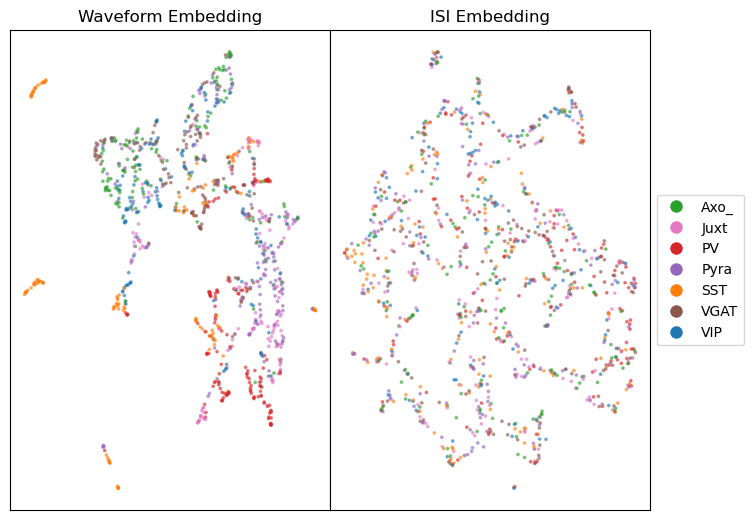

In [21]:
figureWidth=8
figureHeight=6
plt.figure(figsize=(figureWidth,figureHeight))
panel1 = plt.axes([0.1, 0.1, 0.4, 0.8])
panel2 = plt.axes([0.5, 0.1, 0.4, 0.8])

panel1.scatter(embedding_waveform[:, 0], embedding_waveform[:, 1], color=labelColor, s=3, alpha=0.5)
panel1.set_title("Waveform Embedding")
panel1.set_xticks([])
panel1.set_yticks([])
panel2.scatter(embedding_isi[:, 0], embedding_isi[:, 1], color=labelColor, s=3, alpha=0.5)
panel2.set_title("ISI Embedding")
panel2.set_xticks([])
panel2.set_yticks([])

#Plot legend based on unique_labels and labelColor
panel2.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for color, label in zip(labelColor, unique_labels)], loc='center left', bbox_to_anchor=(1, 0.5))


plt.show()

In [22]:
from torch.nn.functional import normalize
class classification(nn.Module):
    def __init__(self, num_labels, **kwargs):
        super().__init__()
        #self.mixedModelAE = MixedModel(**kwargs)
        #self.mixedModelAE.load_state_dict(torch.load('MixedAutoEncoderTemplates.pt'))
        self.wave_model = UnimodalModel(z_dim=5,output_size=50)
        self.time_model = UnimodalModel(z_dim=5,output_size=100)
        self.wave_model.load_state_dict(torch.load('./unimodal_model/wave_model_50.pt'))
        self.time_model.load_state_dict(torch.load('./unimodal_model/time_model_100.pt'))
        for p in self.wave_model.parameters():
            p.requires_grad = False
        for p in self.time_model.parameters():
            p.requires_grad = False
        
        self.classifier = nn.Sequential(nn.Linear(kwargs['z_dim'] * 2, 64), nn.ReLU(),
                                         nn.Linear(64, num_labels))
        #self.classifier = nn.Sequential(nn.Linear(64 * 2, num_labels))
        

    def forward(self, wave,time):
        #e_wave, e_time, d_wave, d_time = self.mixedModelAE(wave,time)
        e_wave,d_wave = self.wave_model(wave)
        e_time,d_time = self.time_model(time)
        e_wave, e_time = normalize(e_wave), normalize(e_time)
        #print(e_wave.shape)
        #print(e_time.shape)
        x = torch.cat((e_wave, e_time), dim=-1).squeeze()
        #print(x.shape)
        output = self.classifier(x)    
        #print(output.shape)    
        return output

In [23]:
classifier = classification(num_labels=7, z_dim=5)
optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

#Training the classifier

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



def train_classifier(classifier, optim, loss_fn, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        cum_loss = 0
        classifier.train()
        correct_train = 0
        total_train = 0
        for i, (wave, time,label) in enumerate(train_loader):
            optimizer.zero_grad()
            output = classifier(wave,time)
            train_predicted = torch.argmax(output, 1)
            total_train += time.size(0)
            correct_train += (train_predicted == label).sum().item()
            loss = loss_fn(output,label)
            cum_loss += loss.item()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch} Iter {i} Loss {cum_loss/len(train_loader)}")
        print(f"Epoch {epoch} Iter {i} Train Accuracy {correct_train / total_train}")
        classifier.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for i, (wave, time,label) in enumerate(val_loader):
                output = classifier(wave,time)
                predicted = torch.argmax(output, 1)
                #print(predicted.shape)
                total += time.size(0)
                correct += (predicted == label).sum().item()
            print(f"Epoch {epoch} Validation Accuracy {correct / total}")
        

In [24]:
train_classifier(classifier, optimizer, loss_fn, dataloader_train, dataloader_val, epochs=100)

Epoch 0 Iter 32 Loss 1.9272355672084924
Epoch 0 Iter 32 Train Accuracy 0.18120805369127516
Epoch 0 Validation Accuracy 0.2277992277992278
Epoch 1 Iter 32 Loss 1.880606026360483
Epoch 1 Iter 32 Train Accuracy 0.2914669223394056
Epoch 1 Validation Accuracy 0.25868725868725867
Epoch 2 Iter 32 Loss 1.8274171533006611
Epoch 2 Iter 32 Train Accuracy 0.34132310642377756
Epoch 2 Validation Accuracy 0.29343629343629346
Epoch 3 Iter 32 Loss 1.7677425109978877
Epoch 3 Iter 32 Train Accuracy 0.3336529242569511
Epoch 3 Validation Accuracy 0.33204633204633205
Epoch 4 Iter 32 Loss 1.6932265397274133
Epoch 4 Iter 32 Train Accuracy 0.37488015340364333
Epoch 4 Validation Accuracy 0.3088803088803089
Epoch 5 Iter 32 Loss 1.650000471057314
Epoch 5 Iter 32 Train Accuracy 0.3815915627996165
Epoch 5 Validation Accuracy 0.3474903474903475
Epoch 6 Iter 32 Loss 1.60390956474073
Epoch 6 Iter 32 Train Accuracy 0.4170661553211889
Epoch 6 Validation Accuracy 0.3590733590733591
Epoch 7 Iter 32 Loss 1.5753339565161504

KeyboardInterrupt: 

In [25]:
def predict_classifier(classifier, dataloader):
    predictions = []
    classifier.eval()
    with torch.no_grad():
        for i, (wave, time,label) in enumerate(dataloader):
            output = classifier(wave,time)
            predicted = torch.argmax(output, 1)
            predictions.append(predicted)
    return predictions

predictions = predict_classifier(classifier, dataloader_val)
predictions = torch.cat(predictions, dim=0).detach().numpy()

In [32]:
len(preds_np)
#Obtain numpy array from dataloader_val
labels = np.array([label_item for _,_,label_batch in dataloader_val for label_item in label_batch])
print(labels.shape)
labels

(259,)


array([3, 4, 2, 5, 0, 6, 1, 3, 4, 2, 5, 0, 6, 1, 3, 4, 2, 5, 0, 6, 1, 3,
       4, 2, 5, 0, 6, 1, 3, 4, 2, 5, 0, 6, 1, 3, 4, 2, 5, 0, 6, 1, 3, 4,
       2, 5, 0, 6, 1, 3, 4, 2, 5, 0, 6, 1, 3, 4, 2, 5, 0, 6, 1, 3, 4, 2,
       5, 0, 6, 1, 3, 4, 2, 5, 0, 6, 1, 3, 4, 2, 5, 0, 6, 1, 3, 4, 2, 5,
       0, 6, 1, 3, 4, 2, 5, 0, 6, 1, 3, 4, 2, 5, 0, 6, 1, 3, 4, 2, 5, 0,
       6, 1, 3, 4, 2, 5, 0, 6, 1, 3, 4, 2, 5, 0, 6, 1, 3, 4, 2, 5, 0, 6,
       1, 3, 4, 2, 5, 0, 6, 1, 3, 4, 2, 5, 0, 6, 1, 3, 4, 2, 5, 0, 6, 1,
       3, 4, 2, 5, 0, 6, 1, 3, 4, 2, 5, 0, 6, 1, 3, 4, 2, 5, 0, 6, 1, 3,
       4, 2, 5, 0, 6, 1, 3, 4, 2, 5, 0, 6, 1, 3, 4, 2, 5, 0, 6, 1, 3, 4,
       2, 5, 0, 6, 1, 3, 4, 2, 5, 0, 6, 1, 3, 4, 2, 5, 0, 6, 1, 3, 4, 2,
       5, 0, 6, 1, 3, 4, 2, 5, 0, 6, 1, 3, 4, 2, 5, 0, 6, 1, 3, 4, 2, 5,
       0, 6, 1, 3, 4, 2, 5, 0, 6, 1, 3, 4, 2, 5, 0, 6, 1])

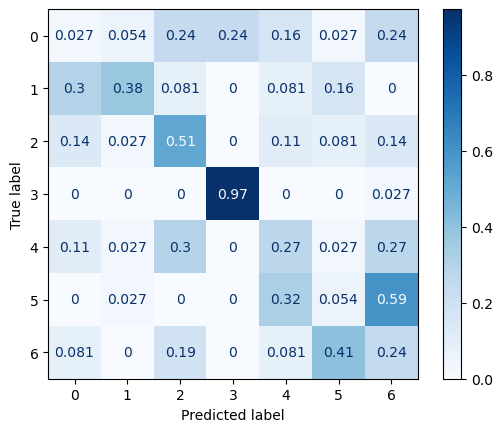

In [33]:
preds_np = predictions
labels_np = labels

# Compute confusion matrix
cm = confusion_matrix(labels_np, preds_np, normalize='true')

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
#Check the embeddings for the predictions and stuff
